<a href="https://colab.research.google.com/github/Ziqiyang72960/MixEHR-SAGE/blob/main/Phenotyping_and_PheWAS_Using_MixEHR_Seed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center; font-size: larger;">

# Phenotyping and PheWAS Using MixEHR-Seed

</div>

<div style="text-align: center; font-size: 20px;">
<strong>Ziqi Yang</strong><br>
<strong>ziqi.yang2@mail.mcgill.ca</strong><br>
<strong>McGill University, School of Computer Science</strong><br>
<strong>June 13, 2025</strong>
</div>

In this notebook, we provide a tutorial for running MixEHR-Seed on electronic health record (EHR) data.

MixEHR-Seed is a expert-guided topic model trained on multi-modal EHR data. The Key content includes

1. **Topic models for EHR**

2. **Understand UKB EHR data**

3. **Run MixEHR-Seed model**

4. **PheWAS application using the generated output**

Please find the link: **github.com/li-lab-mcgill/MixEHR_Seed_Tutorial**

[Li Lab Page](https://www.cs.mcgill.ca/~yueli/research.html) | [Paper](https://dl.acm.org/doi/10.1145/3534678.3542675) | [Project Code](https://github.com/li-lab-mcgill/MixEHR-Seed) | [Jupyter Notebook](https://github.com/li-lab-mcgill/MixEHR_Seed_Tutorial/blob/main/MixEHR_Seed_tutorial.ipynb)


### Environment setup & import required packages

In [1]:
 !git clone https://github.com/Ziqiyang72960/MixEHR-SAGE.git
 import pandas as pd
 import numpy as np
 import sklearn
 from IPython.display import Image

Cloning into 'MixEHR-SAGE'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 142 (delta 25), reused 66 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 1.09 MiB | 2.78 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Filtering content: 100% (13/13), 359.62 MiB | 113.34 MiB/s, done.
Encountered 2 file(s) that should have been pointers, but weren't:
	elbo1.txt
	elbo2.txt


In [ ]:
 %cd /content/MixEHR-SAGE/

/content/MixEHR-SAGE


In [ ]:
# only for github testing purpose or reloading git
import shutil
%cd ../
shutil.rmtree('MixEHR-SAGE')

/content


# 1. Introduction: What is Topic Modeling?

Topic models are probabilistic models that learn **topics** within a collection of documents.

* Each document contains multiple words
* **Each topic is a distribution of words that frequently occur together**
* Each document exhibits different probabilties for topics

Outputs of topic models:

*   Topic representation: a Topic X Vocabulary matrix, each topic is a distribution over words (Φ)
*   Document-topic proportion: a Document X Topic matrix, each document is a distribution of topics (Θ)

<image src='https://raw.githubusercontent.com/Ziqiyang72960/MixEHR-SAGE-tutorial/main/images/topic_model.png'>




### For EHR, the output of the topic model will look like the following:
Topic models learn the co-occurence of words and outputs. It can uncover hidden distributions within the vast amount of unstructured text data in clinical notes, allowing for more efficient and insightful analysis:

* Disease topic representation: each disease topic is a distribution of diagnoses. E.g. Cardiovascular disease topic has frequent heart failure diagnoses
* Patient-topic proportion: the distribution of disease topics for each patient, the probability of a disease topic can be viewed as disease risk


<image src = "https://raw.githubusercontent.com/li-lab-mcgill/MixEHR_Seed_Tutorial/main/images/EHR_modeling.png">


# 2. UKB EHR Data format

UK Biobank has collected and continues to collect extensive environmental, lifestyle, and genetic data on more than half a million participants. New data are uploaded into the database regularly.

UKB dataset contains more than 4900 unique **fields** of phenotypic data:

* Each field represents a type of data (ICD-10, OPCS-4, treatment/medication data)

* An example of variable is 20003-0.3

    - '20003' denotes a field, in this case, treatment/medication codes
    
    - '0' denotes the patient's assessment centre visit, in this case, the initial visit
    
    - '3' denotes the number of records, in this case, the third treatment/medication code
    
    - The variable '20003-0.3' represents the the third treatment/medication code recorded for the patient during the inital visit

<img src="https://raw.githubusercontent.com/li-lab-mcgill/MixEHR-SAGE/main/images/UKB_medication_field.png" alt="UKB Medication Field">





## Process UKB Medication Codes

In the **Field #20003**, UKB database contains patient records of treatment/medication.

| eid     | 20003-0.0   | 20003-0.1   | .... |
|---------|-------------|-------------|------|
| 1000120 | 1140861958  | 1141188146  | .... |
| 1000121 | 1140868226  | 1140876358  |  .... |

UKB database assigns different codes to **varied dosages and different names** of the same medication.

* Hinder model to understand drug information.


| UKB med   | Meaning             |
|-----------|-----------------------------|
| 1140861958 | Simvastatin |
| 1141188146 | Simvador 10mg tablet |
| 1140868226 | Aspirin          |
| 1140876358 | Unguentum cocois co |


### Map UKB medication code to ATC code

The study referenced in [1] provides a mapping between UKB medication codes and ATC codes, which is detailed in the [supplementary material](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-019-09572-5/MediaObjects/41467_2019_9572_MOESM3_ESM.xlsx).

* ATC codes group same active substances that acts on same organ/system

This mapping aligns 6,745 UKB medication codes with 885 distinct ATC codes.

| eid     | UKB med  | ATC |
|---------|------------|----------|
| 1000120 | 1140861958 | C10AA01  |
| 1000120 | 1141188146 | C10AA01  |
| 1000121 | 1140868226 | A01AD05  |
| 1000121 | 1140876358 | Nan  |


Since multiple medication codes can be mapped to a same ATC code, we compute the frequency of ATC codes for each indivudial.

* Rows with ATC code of 'NaN' were excluded from this aggregation


| eid     | UKB med  | ATC | Freq |
|---------|------------|----------|------|
| 1000120 | 1140861958 | C10AA01  | 2    |
| 1000121 | 1140868226 | A01AD05  | 1    |
| ...     | ...        | ...      | ...  |

[1] Wu, Y., Byrne, E.M., Zheng, Z. et al. Genome-wide association study of medication-use and associated disease in the UK Biobank. Nat Commun 10, 1891 (2019). https://doi.org/10.1038/s41467-019-09572-5

## Phenotype-guided Topic Model

The [PheWAS](https://phewascatalog.org/phewas/#phe12) is expert-defined mapping system for disease categorization.

Each disease is defined by a phenotype code (phecode), which corresponds to a set of related ICD codes.

| Disease | Phecode | ICD-10 |
|----------|----------|-------------|
| Asthma  | 495.2   | J45.3, ... |
| COPD    | 496.2   | J44, ... |
| ...     | ...     | ...         |


### Incorporate PheWAS into MixEHR-Seed

View each phecode as a  pre-established disease topic, which is linked to a group of **seed** ICD codes.

MixEHR-Seed model learns regular topic and seed topic:

* Each **regular** topic corresponds to a standard topic in LDA, the distributions across all ICD codes
* Each **seed** toipc is distributed only over its **seed** ICD codes, reflecting expert knowledge


When encounter ICD codes J45.3, it assigns a higher weight for disease topic (495.2 asthma).



## Synthesizing UKB data using existing MixEHR-Seed Φ and Θ output (Today)

When performing the generative process of latent Dirichlet allocation (LDA), we can infer the probability of the disease incidence. Specifically, we inferred the expected patient-by-ICD matrix by multiplying the
patient topic mixture θ ∈ ℝᴰˣᴷ with the topic distribution matrix ϕ ∈ ℝᴷˣⱽ (ICD)
(Φ x Θ).

The patient-topic proportion can be used for automatic phenotyping:


* MixEHR-Seed learns a Patient X Phenotypes (topics) matrix, and each element represents the disease risk for a patient.

* For each phenotype topic, the patients are assigned with low-risk and high-risk scores

* MixEHR-Seed allows to predict thousands of phenotypes simultaneously


## Example of Inferred Probability

We randomly select patients and show the occurence of phecodes (left) and the learned probabilities (right):

* The phecode occurence (left) only gives us **counts**, while MixEHR-Seed provides learned **probabilities**
* The model will adjust probabilities from the correlation between phenotypes


<image src='https://raw.githubusercontent.com/li-lab-mcgill/MixEHR_Seed_Tutorial/main/images/prediction.png'>











LDA source:
[LDA source](https://dl.acm.org/doi/pdf/10.5555/944919.944937)

## Now let's try it

In [ ]:
# Read the phi files
phi_icd = pd.read_csv('UKB_phi_icd.csv', index_col=0)   # ICD x PheCode Matrix
phi_med = pd.read_csv('UKB_phi_med.csv', index_col=0)   # ATC x PheCode Matrix
phi_opcs = pd.read_csv('UKB_phi_opcs.csv', index_col=0) # OPCS-4 x PheCode Matrix
theta = pd.read_csv('theta_sampled.csv')                # Paitent x PheCode Matrix
print(phi_icd.shape, phi_med.shape, phi_opcs.shape, theta.shape)

(4933, 1213) (877, 1213) (3896, 1213) (4000, 1213)


In [ ]:
phi_icd.head()

,599.0 Other symptoms/disorders or the urinary system,502.0 Postinflammatory pulmonary fibrosis,497.0 Bronchitis,172.2 Other non-epithelial cancer of skin,418.0 Nonspecific chest pain,429.2 Abnormal function study of cardiovascular system,764.0 Sciatica,"519.8 Other diseases of respiratory system, NEC",573.7 Abnormal results of function study of liver,714.1 Rheumatoid arthritis,...,395.4 Nonrheumatic pulmonary valve disorders,715.1 Sacroiliitis NEC,145.1 Cancer of lip,521.4 Tooth complications likely association with other diseases,539.0 Bariatric surgery,"149.0 Cancer of larynx, pharynx, nasal cavities",112.3 Candidiasis of skin and nails,259.1 Nonspecific abnormal results of other endocrine function study,"1014.0 Effects of heat, cold and air pressure",988.0 Toxic effect of noxious substances eaten as food
W02.3 Sports and athletics area,0.000215,0.000204,0.000207,0.000085,0.000123,0.000209,0.000199,0.000156,0.000204,0.000185,...,0.000201,0.000201,0.000200,0.000200,0.000201,0.000200,0.000200,0.000201,0.000219,0.000200
S82.20 Fracture of shaft of tibia (closed),0.000291,0.000286,0.000281,0.000083,0.000100,0.000281,0.000265,0.000163,0.000269,0.000243,...,0.000292,0.000291,0.000293,0.000293,0.000292,0.000292,0.000293,0.000292,0.000424,0.000293
"N39.9 Disorder of urinary system, unspecified",0.001986,0.000332,0.000326,0.000066,0.000079,0.000331,0.000303,0.000147,0.000309,0.000271,...,0.000378,0.000373,0.000383,0.000384,0.000375,0.000380,0.000382,0.000378,0.000382,0.000381
M05.80 Other seropositive rheumatoid arthritis (Multiple sites),0.000138,0.000142,0.000144,0.000076,0.000136,0.000146,0.000140,0.000134,0.000143,0.000135,...,0.000136,0.000136,0.000135,0.000134,0.000136,0.000135,0.000135,0.000136,0.000135,0.000135
M06.30 Rheumatoid nodule (Multiple sites),0.000137,0.000147,0.000143,0.000075,0.000136,0.000145,0.000139,0.000133,0.000142,0.000137,...,0.000135,0.000135,0.000134,0.000134,0.000135,0.000134,0.000135,0.000135,0.000134,0.000135


In [ ]:
np.random.seed(42)
def generate_synthetic_data(theta, phi, mean_tokens=15):
    theta_np = theta.to_numpy()
    phi_np = phi.to_numpy()
    prob = np.dot(theta_np, phi_np.T)  # (N x V)

    prob /= prob.sum(axis=1, keepdims=True)
    # the average ICD count for each patient in UKB is around 15
    token_counts = np.random.poisson(mean_tokens, size=theta_np.shape[0])

    synthetic = []
    for i in range(theta_np.shape[0]):
        sample = np.random.multinomial(token_counts[i], prob[i])
        synthetic.append(sample)

    result = np.array(synthetic)
    result = (result > 0).astype(int)

    df_wide = pd.DataFrame(result, columns=phi.index)
    df_wide['SUBJECT_ID'] = df_wide.index

    # Melt the DataFrame to long format
    df_long = df_wide.melt(id_vars='SUBJECT_ID', var_name='code', value_name='presence')

    # Filter to include only codes that are present
    df_long = df_long[df_long['presence'] == 1].reset_index(drop=True)
    df_long = df_long.drop(columns=['presence'])
    df_freq = df_long.value_counts(subset=['SUBJECT_ID', 'code']).reset_index(name='frequency')
    return df_freq


# Run for each modality
synthetic_icd = generate_synthetic_data(theta, phi_icd, mean_tokens=15)
synthetic_med = generate_synthetic_data(theta, phi_med, mean_tokens=4)
synthetic_opcs = generate_synthetic_data(theta, phi_opcs, mean_tokens=5)

icd_mapping = pd.read_csv("phecode_icd10.csv")
synthetic_icd['code'] = synthetic_icd['code'].str.split(' ').str[0]
synthetic_icd = synthetic_icd.merge(icd_mapping, left_on='code', right_on = 'ICD10')
synthetic_icd = synthetic_icd[['SUBJECT_ID','code','PheCode']]

# Save or inspect
synthetic_icd.to_csv("data/synthetic_icd.csv", index=False)
synthetic_med.to_csv("data/synthetic_med.csv", index=False)
synthetic_opcs.to_csv("data/synthetic_opcs.csv", index=False)


In [ ]:
synthetic_icd

,SUBJECT_ID,code,PheCode
0,0,C02.4,145.20
1,0,C18.7,153.20
2,0,C20,153.30
3,0,C67.5,189.21
4,0,E06.9,245.00
...,...,...,...
47034,0,M22.4,835.00
47035,0,S60.0,916.00
47036,0,T91.3,907.00
47037,1,E20.9,252.20


In [ ]:
synthetic_med

,SUBJECT_ID,code,frequency
0,3998,S01AD03 Aciclovir,1
1,0,A01AB08 |A07AA01 |B05CA09 |D06AX04 |J01GB05 |R...,1
2,0,J01FA10 |S01AA26 Azithromycin,1
3,0,J05AB01 Aciclovir,1
4,1,C03AB01 Bendroflumethiazide |Potassium,1
...,...,...,...
15989,8,S01AA01 Chloramphenicol,1
15990,9,A01AC03 |A07EA02 |C05AA01 |D07AA02 |D07XA01 |H...,1
15991,9,J01CR02 Amoxicillin |Clavulanate,1
15992,9,N07AX01 |S01EB01 Pilocarpine,1


In [ ]:
synthetic_opcs

,SUBJECT_ID,code,frequency
0,3999,Z55.1 Flexor muscle of forearm,1
1,0,L63.8 Other specified transluminal operations ...,1
2,0,M09.3 Endoscopic laser fragmentation of calcul...,1
3,0,Z81.7 Inferior radioulnar joint,1
4,1,E63.9 Unspecified diagnostic endoscopic examin...,1
...,...,...,...
20033,1,Z54.2 Rotator cuff of shoulder,1
20034,1,Z76.1 Head of femur,1
20035,2,Y27.1 Autograft to organ NOC,1
20036,3,F14.8 Other specified orthodontic operations,1


# 3. Run MixEHR-Seed Model

MixEHR-Seed improves over classic topic model in two aspects:

* Improvement 1: use PheWAS-guidance about expert-defined phenotypes to learn meaningful disease topics
* Improvement 2: includes multiple data types to learn multi-modal disease topics


Outputs of MixEHR-Seed model:

*   Disease topic representation: For each data type, the disease topic is a distrubtion of words (ICD, medications,...)
*   Patient-topic proportion: Each patient has a distribution of disease topics, indicating disease risk scores




## Step 1: Process Dataset and Extract Seeds


### Prepare data

The EHR data is located in the `./data` directory.

* **Mandatory ICD code**.
Headers:, ICD9, Phecode, Freq


| SUBJECT_ID | ICD10  | Phecode | Freq |
|------------|-------|---------|------|
| 53192      | 49320 | 495.10  | 1    |
| 27098      | 49390 | 494.00  | 2    |
| ...        | ...   | ...     | ...  |

* **Any other types** as complementary information, such as medication.


| SUBJECT_ID | ***type_name***   | Freq |
|------------|-------|------|
| 7981      | Neutra-Phos | 1    |
| 12080      | Heparin | 2    |
| ...        | ...   | ...  |


### Process data

This procedure generates a ***Corpus*** object that can be executed by the MixEHR-Seed model. To generate and save the processed corpus in the `./store` directory, execute the `./corpus.py` with the following command:

```
run(parser.parse_args(['process', '-n', '150', './data/', './store/']))
```

In [ ]:
%run ./corpus.py process -n 150 ./data/ ./store/

./data/
./store/
                            path word_column
index                                       
icd     ./data/synthetic_icd.csv        code
med     ./data/synthetic_med.csv        code
opcs   ./data/synthetic_opcs.csv        code
['icd', 'med', 'opcs']
{'icd': './data/synthetic_icd.csv', 'med': './data/synthetic_med.csv', 'opcs': './data/synthetic_opcs.csv'}
{'icd': 'code', 'med': 'code', 'opcs': 'code'}
       SUBJECT_ID   code  PheCode
0               0  C02.4   145.20
1               0  C18.7   153.20
2               0    C20   153.30
3               0  C67.5   189.21
4               0  E06.9   245.00
...           ...    ...      ...
47034           0  M22.4   835.00
47035           0  S60.0   916.00
47036           0  T91.3   907.00
47037           1  E20.9   252.20
47038           1  I25.1   411.40

[47039 rows x 3 columns]
       SUBJECT_ID                                               code  \
0            3998                                  S01AD03 Aciclovir   
1 

100.0000  - document(1), word(470): 100%|██████████| 47039/47039 [00:34<00:00, 1376.53it/s]


1 med


100.0000  - document(10), word(264): 100%|██████████| 15994/15994 [00:11<00:00, 1372.40it/s]


2 opcs


100.0000  - document(3), word(823): 100%|██████████| 20038/20038 [00:14<00:00, 1371.88it/s]


In [ ]:
%cd guide_prior
%run ./get_doc_phecode.py
%run ./get_prior_GMM.py
%run ./get_token_counts.py
%cd ..

/content/MixEHR-SAGE/guide_prior
done
obtain D x K document-PheCode count matrix
(4000, 1376)
[3576, 877, 3853]
/content/MixEHR-SAGE


In [ ]:
%run ./main.py

# each epoch will generate a

cuda
V and K are torch.Size([3576, 1376])
trained modalities include ['icd', 'med', 'opcs']
Obtain initialized tokens
Training for 0 epoch
Running for 0 minibatch


/content/MixEHR-SAGE/MixEHR_Seed.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_sum_s_terms += lgamma(torch.tensor(self.mu_sum[k])) \


Running for 1 minibatch
Running for 2 minibatch
Running for 3 minibatch
Training for 1 epoch
Running for 0 minibatch
Running for 1 minibatch
Running for 2 minibatch
Running for 3 minibatch
Training for 2 epoch
Running for 0 minibatch
Running for 1 minibatch
Running for 2 minibatch
Running for 3 minibatch
Training for 3 epoch
Running for 0 minibatch
Running for 1 minibatch
Running for 2 minibatch
Running for 3 minibatch
Training for 4 epoch
Running for 0 minibatch
Running for 1 minibatch
Running for 2 minibatch
Running for 3 minibatch


## Step 2: Evaluation
The outputs are saved at ./results/, we can evaluate the topic interpretability and phenotype prediction.

We can plot the heatmap by showing the top 3 code for each topic for all three modalities

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


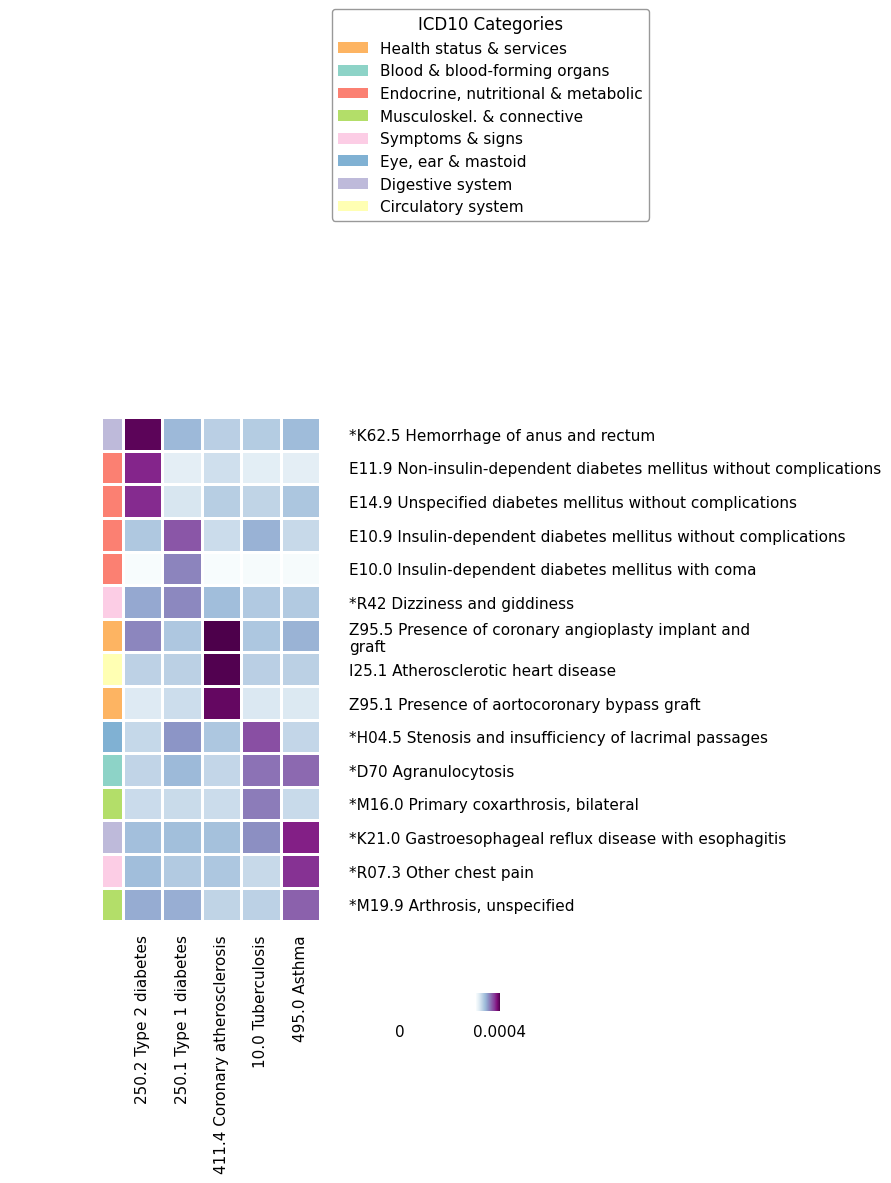

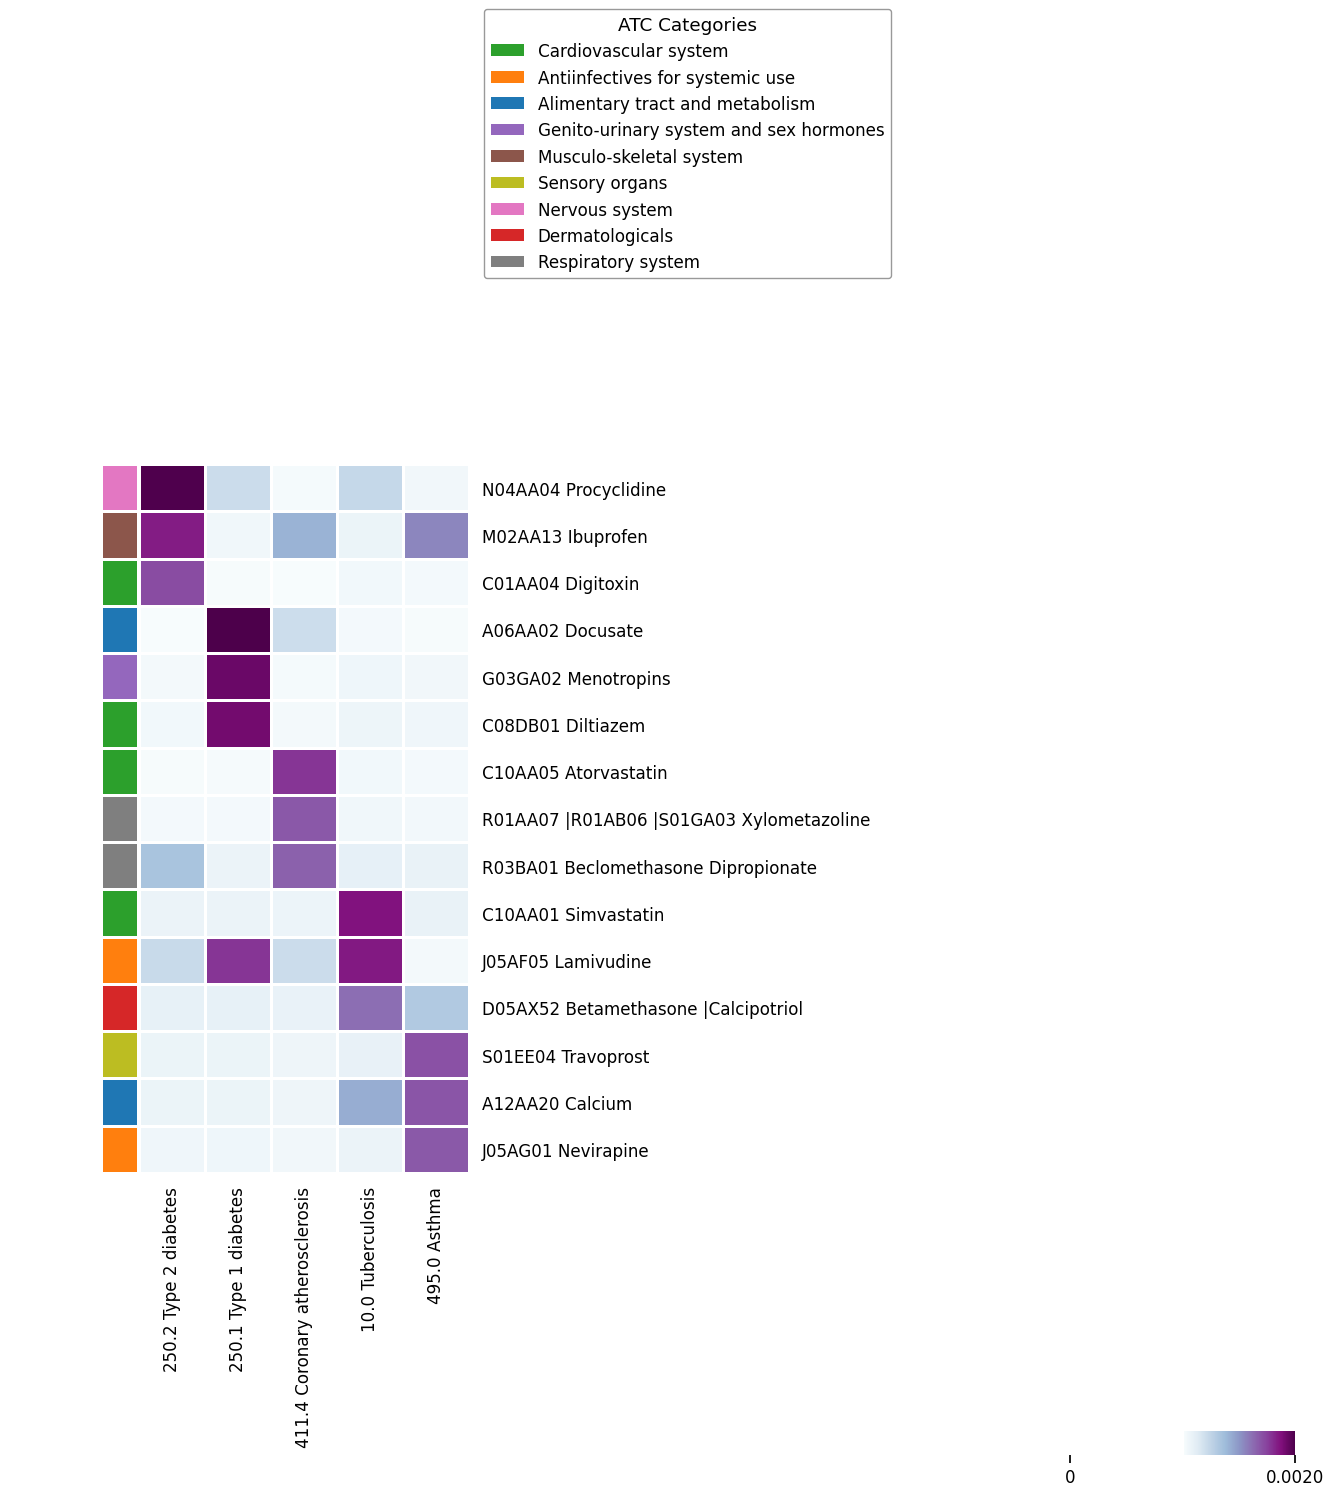

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


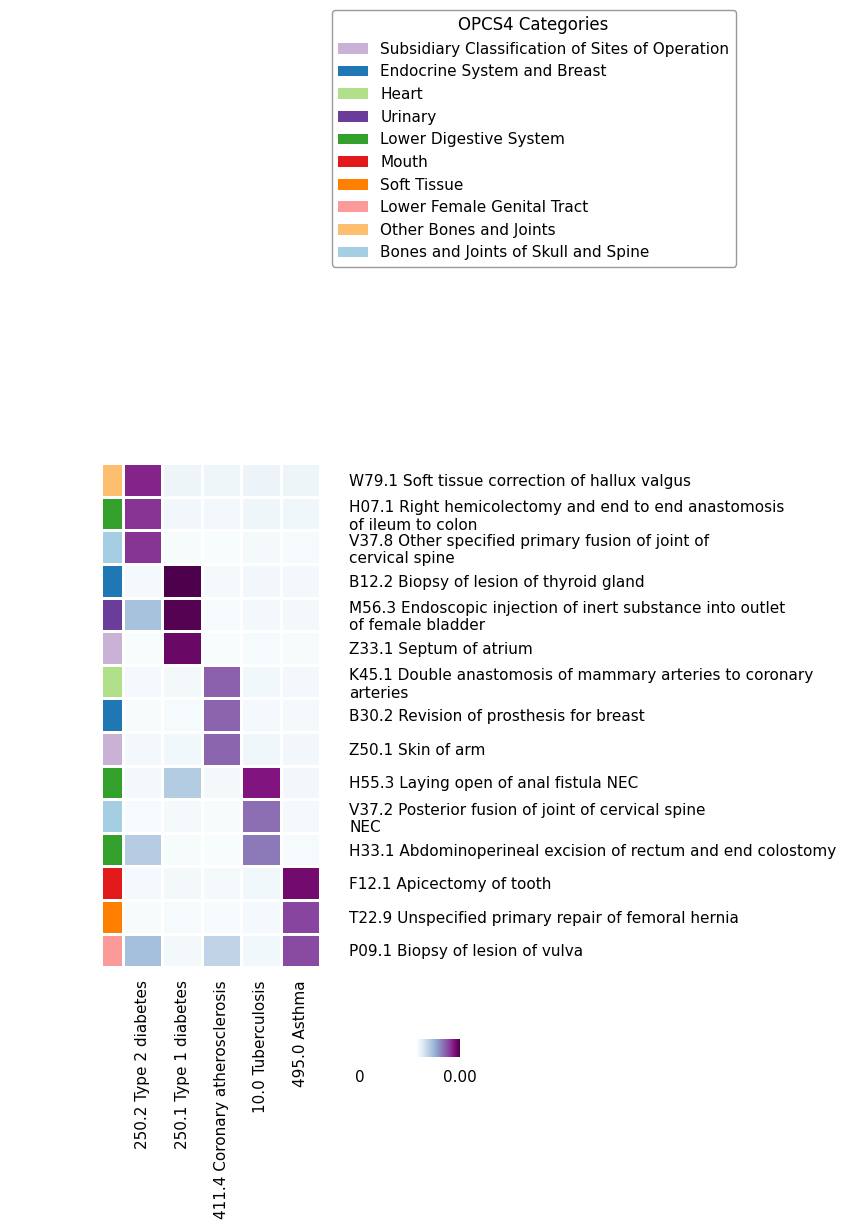

<Figure size 640x480 with 0 Axes>

In [ ]:
%run plotting.py

# Genotype Integration: 1000 Genomes + GWAS Prep - If time allows

In this section, we demonstrate how to integrate synthetic phenotypes with real genotype data from the 1000 Genomes Project. This enables downstream genome-wide association studies (GWAS) using our simulated phenotypes derived from MixEHR-SAGE.

### 4.1 Overview of 1000 Genomes Dataset

- Publicly available dataset representing diverse human populations.
- Contains ~2,500 individuals from 26 global populations.
- For this tutorial, we focus on the **European (EUR)** subset to match the population profile of UK Biobank.

The dataset in bed/bim/fam version can be downloaded through: https://zenodo.org/records/6614170#:~:text=Genotype%20data%20for%20individuals%20from,against%20GEUVADIS%20gene%20expression%20phenotypes.


In [ ]:
!wget https://zenodo.org/records/6614170/files/1000G_EUR.fam
!wget https://zenodo.org/records/6614170/files/1000G_EUR.bed
!wget https://zenodo.org/records/6614170/files/1000G_EUR.bim

--2025-06-04 14:24:21--  https://zenodo.org/records/6614170/files/1000G_EUR.fam
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9557 (9.3K) [application/octet-stream]
Saving to: ‘1000G_EUR.fam.1’

1000G_EUR.fam.1     100%[===================>]   9.33K  --.-KB/s    in 0.001s  

2025-06-04 14:24:22 (12.6 MB/s) - ‘1000G_EUR.fam.1’ saved [9557/9557]

--2025-06-04 14:24:22--  https://zenodo.org/records/6614170/files/1000G_EUR.bed
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231387159 (221M) [application/octet-stream]
Saving to: ‘1000G_EUR.bed’

1000G_EUR.bed       100%[===================>] 220.67M  2.67MB/s    in 2m 1s   

2025-06-04 14:26:23 (1.83 MB/s) - ‘100

In [ ]:
# Download Plink 1.9
!wget -q https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip
!unzip -q plink_linux_x86_64_20210606.zip
!chmod +x plink

In [ ]:
!./plink --help # testing

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3

In the command line flag definitions that follow,
  * <angle brackets> denote a required parameter, where the text between the
    angle brackets describes its nature.
  * ['square brackets + single-quotes'] denotes an optional modifier.  Use the
    EXACT text in the quotes.
  * [{bar|separated|braced|bracketed|values}] denotes a collection of mutually
    exclusive optional modifiers (again, the exact text must be used).  When
    there are no outer square brackets, one of the choices must be selected.
  * ['quoted_text='<description of value>] denotes an optional modifier that
    must begin with the quoted text, and be followed by a value with no
    whitespace in between.  '|' may also be used here to indicate mutually
    exclusive options.
  * [square brackets without quotes or braces] denote an optional parameter,
    whe

### 4.2 PCA and Covariate Control

- Compute **Principal Components (PCs)** from genotype data using PLINK:

- Description of key options:

    --bfile: Specifies the base name of the PLINK binary genotype dataset.

    --Computes the top 10 principal components.

    --out: Sets the prefix for output files.

In [ ]:
!./plink \
  --bfile '/content/drive/MyDrive/Colab Notebooks/1000G_EUR' \
  --pca 10 \
  --out 1000G_EUR_pca

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000G_EUR_pca.log.
Options in effect:
  --bfile /content/drive/MyDrive/Colab Notebooks/1000G_EUR
  --out 1000G_EUR_pca
  --pca 10

54231 MB RAM detected; reserving 27115 MB for main workspace.
1836406 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
Using up to 11 threads (change this with --threads).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%

In [ ]:
fam = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1000G_EUR.fam", delimiter='\t', header=None)
pcs = pd.read_csv("1000G_EUR_pca.eigenvec", delimiter = ' ', header=None)

covar = pd.DataFrame()
covar[0] = fam[0]  # FID
covar[1] = fam[1]  # IID
covar[2] = fam[4].replace({1: 1, 2: 0})  # SEX
covar = pd.concat([covar, pcs.iloc[:, 2:]], axis=1)  # Add PCs
covar.to_csv("covariates.txt", sep=' ', index=False, header=False)

### 4.3 Aligning Individuals (Only for dispaly purporses)

- We randomly sampled 4,000 individuals’ phenotypes from MixEHR-SAGE synthetic θ.
- To simulate GWAS realistically, we **randomly select 1:1 mapping individuals** between these phenotypes and the 1000 Genomes individuals.



In [ ]:
i = 91
phenotype_scores = np.dot(theta.to_numpy(), phi_icd.to_numpy().T)
phenotype_scores = phenotype_scores[:, i]
phenotype_scores

array([0.00039596, 0.00039647, 0.0003995 , ..., 0.00039636, 0.00039614,
       0.00039666])

In [ ]:
inv_phecode_ids[91]

np.float64(859.0)

In [ ]:
import random
n = len(phenotype_scores)

# Randomly select 503 unique indices
selected_indices = random.sample(range(n), 503)
phenotype_i = pd.DataFrame({
    'FID': fam[0].values,
    'IID': fam[1].values,
    'PHENO': [phenotype_scores[i] for i in selected_indices]
})

# Step 5: Save the phenotype data to a tab-delimited text file
phenotype_i.to_csv('synthetic_phenotype_i.txt', sep='\t', index=False, header = None)

Description of key options:

--bfile: Specifies the base name of the PLINK binary genotype dataset.

--linear: Performs linear regression for a continuous phenotype.

hide-covar: Hides covariate regression coefficients in the output.

--allow-no-sex: Ignores missing sex information in the .fam file.

--maf 0.001: Filters variants with minor allele frequency (MAF) below 0.1%.

--mac 5: Filters variants with minor allele count (MAC) less than 5.

--covar: Specifies a file containing covariates (e.g., sex, PCs).

--pheno: Specifies the file containing synthetic phenotype values.

--threads: Number of CPU threads to speed up computation.

--out: Sets the prefix for output files.

In [ ]:
!./plink --bfile "/content/drive/MyDrive/Colab Notebooks/1000G_EUR" \
       	  --linear hide-covar \
        	--allow-no-sex \
		      --maf 0.001 \
        	--mac 5 \
		      --covar "covariates.txt" \
		      --threads 5 \
		      --pheno "synthetic_phenotype_i.txt"  \
        	--out "plink_1000g_sample"

PLINK v1.90b6.24 64-bit (6 Jun 2021)           www.cog-genomics.org/plink/1.9/
(C) 2005-2021 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink_1000g_sample.log.
Options in effect:
  --allow-no-sex
  --bfile /content/drive/MyDrive/Colab Notebooks/1000G_EUR
  --covar covariates.txt
  --linear hide-covar
  --mac 5
  --maf 0.001
  --out plink_1000g_sample
  --pheno synthetic_phenotype_i.txt
  --threads 5

54231 MB RAM detected; reserving 27115 MB for main workspace.
1836406 variants loaded from .bim file.
503 people (240 males, 263 females) loaded from .fam.
503 phenotype values present after --pheno.
Using 1 thread.
currently disregard the --threads limit.  If this is problematic, you may want
to recompile against single-threaded BLAS/LAPACK.
--covar: 11 covariates loaded.
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17

In [ ]:
summary_stats = pd.read_csv("plink_1000g_sample.assoc.linear", sep='\s+')
summary_stats

,CHR,SNP,BP,A1,TEST,NMISS,BETA,STAT,P
0,1,rs3131972,752721,A,ADD,503,-4.383000e-08,-0.5833,0.56000
1,1,rs12184325,754105,T,ADD,503,-1.575000e-08,-0.1150,0.90850
2,1,rs3131969,754182,A,ADD,503,-3.795000e-08,-0.4755,0.63460
3,1,rs3131967,754334,T,ADD,503,-3.795000e-08,-0.4755,0.63460
4,1,rs3131962,756604,A,ADD,503,-4.809000e-08,-0.6061,0.54480
...,...,...,...,...,...,...,...,...,...
1642499,22,rs3865764,51185848,G,ADD,503,-7.687000e-08,-0.6956,0.48700
1642500,22,rs142680588,51193629,G,ADD,503,3.920000e-08,0.4154,0.67800
1642501,22,rs3888396,51211392,C,ADD,503,-8.205000e-08,-1.1560,0.24810
1642502,22,rs2238837,51212875,C,ADD,503,9.924000e-08,1.7940,0.07343


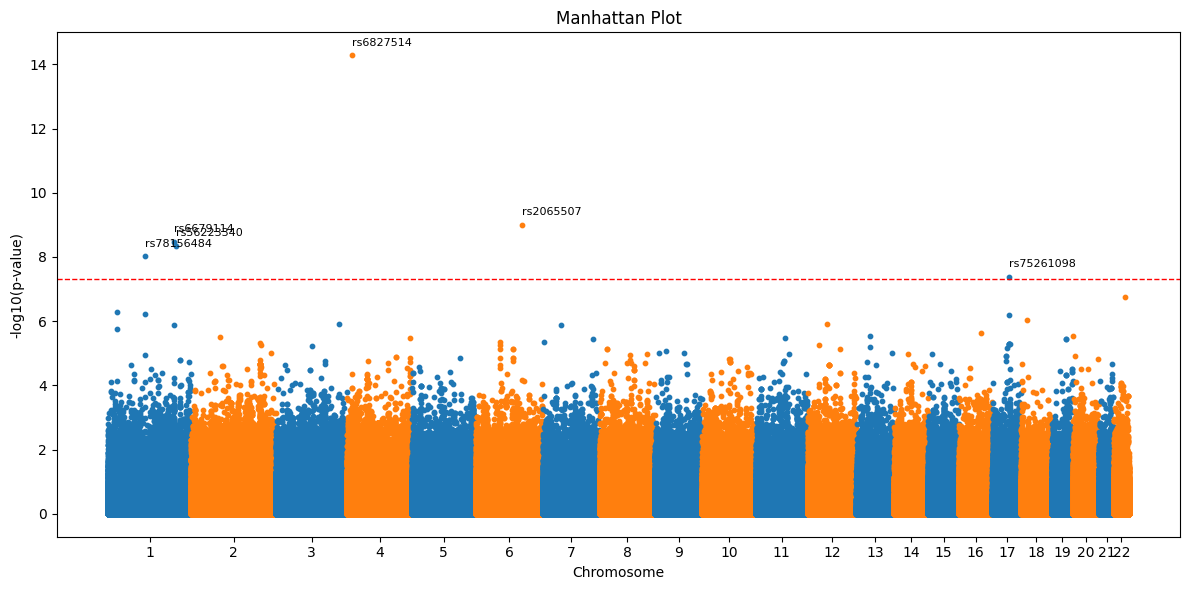

In [ ]:
import matplotlib.pyplot as plt
summary_stats = summary_stats.dropna(subset=['CHR', 'BP', 'P'])

summary_stats = summary_stats.sort_values(['CHR', 'BP'])

# Create a new column for cumulative base-pair position
summary_stats['ind'] = range(len(summary_stats))
summary_stats['-log10(P)'] = -np.log10(summary_stats['P'])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e']  # Alternate colors for chromosomes
x_labels = []
x_labels_pos = []

# Group data by chromosome
for i, (chr_num, group) in enumerate(summary_stats.groupby('CHR')):
    group.plot(kind='scatter', x='ind', y='-log10(P)', color=colors[i % len(colors)], ax=ax, s=10)
    x_labels.append(chr_num)
    x_labels_pos.append((group['ind'].iloc[-1] + group['ind'].iloc[0]) / 2)

# Customize the plot
ax.set_xlabel('Chromosome')
ax.set_ylabel('-log10(p-value)')
ax.set_title('Manhattan Plot')
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.axhline(y=-np.log10(5e-8), color='red', linestyle='--', linewidth=1)

# Annotate SNPs with p-value below a threshold (e.g., 5e-8)
significance_threshold = 5e-8
significant_snps = summary_stats[summary_stats['P'] < significance_threshold]

for _, row in significant_snps.iterrows():
    ax.text(row['ind']-0.1, row['-log10(P)'] + 0.3, row['SNP'], fontsize=8)

plt.tight_layout()
plt.show()


# Practice and exercise afterward

## Using existing UKB synthetic data.

* https://biobank.ndph.ox.ac.uk/synthetic_dataset/

* tabular/string_fields2.tsv (ICD (41270) and OPCS-4 code (41272))
* tabular/integer_arrays_part2.tsv (Medication code (20003))
* First 3000 individuals of the synthetic dataset is provided in the same github repository (**ukb_synthetic_{icd/med/opcs}.csv**)